In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
google-cloud-aiplatform 0.6.0a1 requires google-cloud-storage<2.0.0dev,>=1.26.0, but you have google-cloud-storage 2.1.0 which is incompatible.
gcsfs 2022.2.0 requires fsspec==2022.02.0, but you have fsspec 2022.3.0 which is incompatible.
en-core-web-sm 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.5.3 which is incompatible.
en-core-web-lg 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.5.3 which is incompatible.
apache-beam 2.37.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
apache-beam 2.37.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.4 which is incompatible.
apache-beam 2.37.0 requires pyarrow<7.0.0,>=0.15.1, but you have pyarrow 7.0.0 which is incompatibl

## Step 1: Download images of AI and Offices

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('AI photos', max_images=1)
urls[0]

Searching for 'AI photos'


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://images.news18.com/ibnlive/uploads/2021/01/1611836444_untitled-design-2021-01-28t175010.330.jpg'

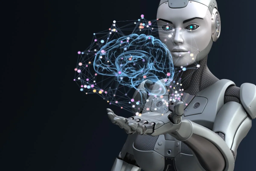

In [5]:
from fastdownload import download_url
dest = 'AI.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'office photos'


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


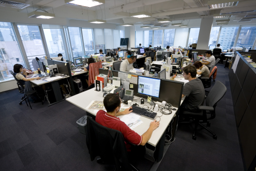

In [6]:
download_url(search_images('office photos', max_images=1)[0], 'office.jpg', show_progress=True)
Image.open('office.jpg').to_thumb(256,256)

In [7]:
searches = 'AI','office'
path = Path('AI_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} daytime photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} nightime photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'AI photo'
Searching for 'AI daytime photo'
Searching for 'AI nightime photo'
Searching for 'office photo'
Searching for 'office daytime photo'
Searching for 'office nightime photo'


## Step 2: Train Model

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

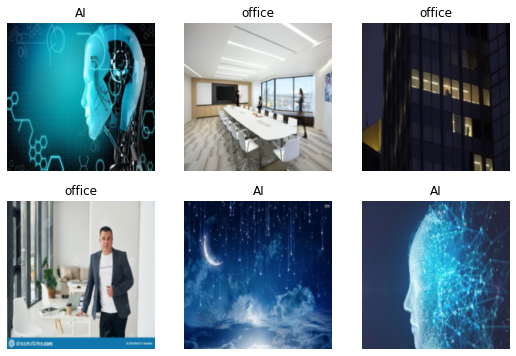

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.246126,0.366645,0.156250,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.267755,0.283980,0.125000,00:13
1,0.191331,0.281763,0.093750,00:13
2,0.147969,0.246929,0.125000,00:13


## Step 3: Use Model

In [11]:
is_AI,_,probs = learn.predict(PILImage.create('AI.jpg'))
print(f"This is a: {is_AI}.")
print(f"Probability it's AA: {probs[0]:.4f}")

This is a: AI.
Probability it's AA: 0.8422
